In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [ ]:
import pandas as pd
import numpy as np

class SolarDataProcessor:
    """
    A class for processing and combining solar inverter data with weather data.

    This class handles the preprocessing of inverter data by splitting it by inverter,
    filling missing values, and combining with weather data.
    """

    def __init__(self):
        """Initialize the SolarDataProcessor."""
        self.df = None
        self.weather_df = None
        self.combined_df = None

    def read_data(self, inverter_csv_path, weather_csv_path):
        """
        Read the inverter and weather data from CSV files.

        Parameters:
        inverter_csv_path (str): Path to the inverter CSV file
        weather_csv_path (str): Path to the weather CSV file
        """
        self.df = pd.read_csv(inverter_csv_path)
        self.weather_df = pd.read_csv(weather_csv_path)

        # Set pandas display options
        pd.set_option('display.max_columns', None)

        return self

    def split_inverter_data(self):
        """
        Split the inverter data by inverter number (1-3) and clean column names.
        """
        # Define additional columns to include in each inverter DataFrame
        additional_columns = ["Date", "Time"]

        # Initialize dictionary to store inverter columns
        inverter_columns = {1: [], 2: [], 3: []}

        # Identify columns for each inverter
        for col in self.df.columns:
            if "INVERTER 1" in col:
                inverter_columns[1].append(col)
            elif "INVERTER 2" in col:
                inverter_columns[2].append(col)
            elif "INVERTER 3" in col:
                inverter_columns[3].append(col)

        # Create DataFrames for each inverter and rename columns
        inverter_dfs = {}
        for inverter, cols in inverter_columns.items():
            # Ensure additional columns are included
            cols_with_additional = additional_columns + cols

            # Clean column names by removing the inverter identifier
            clean_cols = [col.replace(f"INVERTER {inverter}", "") for col in cols]

            # Keep the original names for additional columns
            clean_cols = additional_columns + clean_cols

            # Create a DataFrame for each inverter
            inverter_dfs[inverter] = self.df[cols_with_additional].copy()
            inverter_dfs[inverter].columns = clean_cols
            inverter_dfs[inverter].columns = inverter_dfs[inverter].columns.str.strip()

        one = inverter_dfs[1]
        two = inverter_dfs[2]
        three = inverter_dfs[3]

        return one, two, three

    def fill_missing_data(self, one, two, three):
        """
        Fill short gaps in solar inverter data using linear interpolation.
        """
        # Define the fill_missing_solar_data function
        def fill_missing_solar_data(df, columns):
            """
            Fill short gaps in solar inverter data using linear interpolation

            Parameters:
            df: DataFrame with datetime index
            columns: List of columns to process
            """
            df_filled = df.copy()

            for column in columns:
                if column not in df.columns:
                    print(f"Column '{column}' not found in DataFrame.")
                    continue

                # Simple linear interpolation for gaps up to 4 points
                df_filled[column] = df_filled[column].interpolate(
                    method='linear',
                    limit=4  # Only fill gaps of 4 or fewer points
                )
            return df_filled

        def interpolate_outliers(df, columns, factor=1.5):
          """
          Detect and replace outliers using IQR and linear interpolation.

          Parameters:
          - df: pd.DataFrame — Input DataFrame.
          - columns: list — Columns to check for outliers.
          - factor: float — IQR multiplier for determining outlier thresholds (default=1.5).

          Returns:
          - pd.DataFrame — DataFrame with outliers replaced via interpolation.
          """
          df_clean = df.copy()

          for col in columns:
              if col in ["Date", "Time"]:
                  continue

              Q1 = df_clean[col].quantile(0.25)
              Q3 = df_clean[col].quantile(0.75)
              IQR = Q3 - Q1
              lower_bound = Q1 - factor * IQR
              upper_bound = Q3 + factor * IQR

              # Mark outliers as NaN
              mask_outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
              df_clean.loc[mask_outliers, col] = np.nan

              # Interpolate to fill in outliers
              df_clean[col] = df_clean[col].interpolate(limit_direction='both')

          return df_clean


        cols1 = [col for col in one.columns if col not in ["Date", "Time"]]
        cols2 = [col for col in two.columns if col not in ["Date", "Time"]]
        cols3 = [col for col in three.columns if col not in ["Date", "Time"]]

        one = interpolate_outliers(one, cols1)
        two = interpolate_outliers(two, cols2)
        three = interpolate_outliers(three, cols3)

        one = fill_missing_solar_data(one, cols1)
        two = fill_missing_solar_data(two, cols2)
        three = fill_missing_solar_data(three, cols3)

        return one, two, three

    def combine_inverter_dfs(self, one, two, three):
        """
        Combine the three inverter DataFrames into a single DataFrame.
        """
        # Rename columns to include inverter number suffixes
        one = one.rename(columns={col: f"{col}_inv1" for col in one.columns if col not in ["Date", "Time"]})
        two = two.rename(columns={col: f"{col}_inv2" for col in two.columns if col not in ["Date", "Time"]})
        three = three.rename(columns={col: f"{col}_inv3" for col in three.columns if col not in ["Date", "Time"]})

        # Merge the three DataFrames on "Date" and "Time"
        df = one.merge(two, on=["Date", "Time"]).merge(three, on=["Date", "Time"])

        # Identify unique metric types by extracting column names without inverter numbers
        metric_types = set(col.rsplit("_", 1)[0] for col in df.columns if col not in ["Date", "Time"])

        # Aggregate metrics
        for metric in metric_types:
            # Select all inverter columns for this metric based on suffixes
            columns_to_combine = [col for col in df.columns if col.startswith(metric) and col not in ["Date", "Time"]]

            # Combine the columns (sum or mean, depending on metric type)
            if any(word in metric.lower() for word in ["power", "energy", "connections"]):
                df[f"total_{metric}"] = df[columns_to_combine].sum(axis=1)
            elif any(word in metric.lower() for word in ["temperature", "average", "percent"]):
                df[f"average_{metric}"] = df[columns_to_combine].mean(axis=1)
            else:
                df[f"total_{metric}"] = df[columns_to_combine].sum(axis=1)

            # Drop the original columns for this metric
            df.drop(columns=columns_to_combine, inplace=True)

        self.combined_df = df
        return self


    def add_datetime_and_hour(self):
        self.combined_df['Datetime'] = pd.to_datetime(self.combined_df['Date'] + ' ' + self.combined_df['Time'])
        self.combined_df['hour'] = self.combined_df['Datetime'].dt.hour

        self.weather_df['Datetime'] = pd.to_datetime(self.weather_df['Date'] + ' ' + self.weather_df['Time'])
        self.weather_df['hour'] = self.weather_df['Datetime'].dt.hour

        self.combined_df = self.combined_df.sort_values('Datetime')
        self.weather_df = self.weather_df.sort_values('Datetime')

        return self

    def merge_weather_data(self):
        self.combined_df = pd.merge_asof(self.combined_df, self.weather_df, on='Datetime', direction='nearest')

        self.combined_df = self.combined_df.drop(columns=['hour_x', 'Date_y', 'Time_y'])
        self.combined_df = self.combined_df.rename(columns={
            'Date_x':'date',
            'Time_x':'time',
            'hour_y':'hour'
        })
        return self

    def resample_time_series(self, data, interval='10min', fill_methods=None, default_fill_method='interpolate'):
        """
        Resample a time series dataset to a consistent interval with column-specific fill methods.

        Parameters:
        -----------
        file_path : str
            Path to the CSV file containing the time series data.
        interval : str, default='15min'
            Resampling interval. Examples: '1min', '5min', '15min', '1H', '1D'.
            Use pandas frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
        fill_methods : dict, default=None
            Dictionary mapping column names to specific fill methods.
            Example: {'total_output_power_kW': 'interpolate', 'total_grid_connections': 'forward'}
            Available methods: 'interpolate', 'forward', 'backward', 'mean', 'none'
        default_fill_method : str, default='interpolate'
            Default method to fill missing values for columns not specified in fill_methods.

        Returns:
        --------
        pandas.DataFrame
            Resampled dataset with consistent time intervals.
        """
        df = data

        if 'Datetime' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
        else:
            df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        df.set_index('Datetime', inplace=True)

        original_rows = len(df)
        start_time = df.index.min()
        end_time = df.index.max()

        time_diffs = df.index.to_series().diff().dropna()
        print(f"Original time intervals:")
        print(f"  Min: {time_diffs.min()}")
        print(f"  Max: {time_diffs.max()}")
        print(f"  Mean: {time_diffs.mean()}")
        print(f"  Median: {time_diffs.median()}")

        if fill_methods is None:
            fill_methods = {}

        # get numeric columns
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

        # empyt dataframe to store resampled results
        df_resampled = pd.DataFrame(index=pd.date_range(start=start_time, end=end_time, freq=interval))

        # Process each column with appropriate fill method
        for col in numeric_cols:
            fill_method = fill_methods.get(col, default_fill_method)

            col_resampled = df[col].resample(interval)

            if fill_method == 'interpolate':
                col_data = col_resampled.interpolate(method='time')
            elif fill_method == 'forward':
                col_data = col_resampled.ffill()
            elif fill_method == 'backward':
                col_data = col_resampled.bfill()
            elif fill_method == 'mean':
                col_data = col_resampled.mean()
            elif fill_method == 'none':
                col_data = col_resampled.asfreq()
            else:
                raise ValueError(f"Invalid fill_method '{fill_method}' for column '{col}'. Choose from 'interpolate', 'forward', 'backward', 'mean', 'none'.")

            df_resampled[col] = col_data

        # Check to see if there aer stilll NaN values
        nan_counts = df_resampled.isna().sum()
        if nan_counts.sum() > 0:
            print("\nColumns with NaN values after initial filling:")
            print(nan_counts[nan_counts > 0])

            print("\nFilling remaining NaNs with fallback methods...")
            for col in df_resampled.columns:
                if df_resampled[col].isna().sum() > 0:
                    #  try intrepolation
                    df_resampled[col] = df_resampled[col].interpolate(method='time', limit_direction='both')

                    # If there are still NaNs, use forward then backward fill
                    if df_resampled[col].isna().sum() > 0:
                        df_resampled[col] = df_resampled[col].ffill().bfill()

        resampled_rows = len(df_resampled)
        print(f"\nResampled dataset: {resampled_rows} rows")
        print(f"Rows {'added' if resampled_rows > original_rows else 'removed'}: {abs(resampled_rows - original_rows)}")

        # finall check
        final_nan_counts = df_resampled.isna().sum()
        if final_nan_counts.sum() > 0:
            print("\nWarning: There are still NaN values in these columns:")
            print(final_nan_counts[final_nan_counts > 0])
        else:
            print("\nAll NaN values have been successfully filled.")

        self.combined_df = df_resampled

        return self


    def process_data(self, inverter_csv_path, weather_csv_path):
        """
        Process the data from start to finish in a single method call.
        ****** If you want to use the resample_time_series method, you will have to add to this method. I added it so we can get the timestamps at the same resolution
            it automatically updates the combined_df so all you should have to add to this method is self.resample_time_series()

        """
        self.read_data(inverter_csv_path, weather_csv_path)
        one, two, three = self.split_inverter_data()
        one, two, three = self.fill_missing_data(one, two, three)
        self.combine_inverter_dfs(one, two, three)
        self.add_datetime_and_hour()
        self.merge_weather_data()
        self.resample_time_series(data=self.combined_df)

        return self.combined_df  # Ensure you return the actual processed DataFrame

# example usage
processor = SolarDataProcessor()
df = processor.process_data('/content/drive/MyDrive/Inv_2024-09-30.csv', '/content/drive/MyDrive/weather_2024-09-30.csv')

Original time intervals:
  Min: 0 days 00:01:00
  Max: 0 days 01:34:00
  Mean: 0 days 00:01:05.072415453
  Median: 0 days 00:01:00

Resampled dataset: 8784 rows
Rows removed: 72208

All NaN values have been successfully filled.


In [ ]:
df.columns

Index(['total_time_run_total_h', 'total_Export Energy',
       'total_yesterdays_energy_kWh', 'total_output_current_A',
       'total_output_power_kW', 'average_average_cosphii_percent',
       'total_net_frequency_Hz', 'total_Accumulated Export Energy',
       'total_DC_voltage_DCV', 'average_temperature_C',
       'total_net_AC_voltage_V', 'total_time_run_yesterday_h',
       'total_grid_connections', 'total_time_run_today_h',
       'total_last_active_fault', 'total_energy_counter_MWh',
       'total_todays_energy_kWh', 'WMS 01 ambient_temperature',
       'WMS 01 irradiance', 'WMS 01 wind_speed', 'hour'],
      dtype='object')

In [ ]:
df = df.reset_index()

In [ ]:
df

,total_net_frequency_Hz,average_temperature_C,total_yesterdays_energy_kWh,total_Accumulated Export Energy,total_Export Energy,total_output_current_A,total_output_power_kW,total_DC_voltage_DCV,total_time_run_yesterday_h,total_grid_connections,total_time_run_today_h,total_todays_energy_kWh,total_net_AC_voltage_V,total_energy_counter_MWh,total_time_run_total_h,total_last_active_fault,average_average_cosphii_percent,WMS 01 ambient_temperature,WMS 01 irradiance,WMS 01 wind_speed,hour
2024-08-01 00:00:00,0.0,0.0,27040.0,0.0,0.0,0.0,0.0,0.0,22.0,27256.0,25.0,32470.0,0.0,59194.0,84561.0,219.0,0.0,28.0,0.0,19.0,0.0
2024-08-01 00:30:00,0.0,0.0,27040.0,0.0,0.0,0.0,0.0,0.0,22.0,27256.0,25.0,32470.0,0.0,59194.0,84561.0,219.0,0.0,28.0,0.0,27.0,0.0
2024-08-01 01:00:00,0.0,0.0,27040.0,0.0,0.0,0.0,0.0,0.0,22.0,27256.0,25.0,32470.0,0.0,59194.0,84561.0,219.0,0.0,28.0,0.0,24.0,1.0
2024-08-01 01:30:00,0.0,0.0,27040.0,0.0,0.0,0.0,0.0,0.0,22.0,27256.0,25.0,32470.0,0.0,59194.0,84561.0,219.0,0.0,27.0,0.0,16.0,1.0
2024-08-01 02:00:00,0.0,0.0,27040.0,0.0,0.0,0.0,0.0,0.0,22.0,27256.0,25.0,32470.0,0.0,59194.0,84561.0,219.0,0.0,27.0,0.0,27.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30 21:30:00,0.0,0.0,39140.0,20000.0,0.0,0.0,0.0,0.0,25.0,27882.0,29.0,42500.0,0.0,60235.1,86140.0,219.0,0.0,27.0,0.0,0.0,21.0
2024-09-30 22:00:00,0.0,0.0,39140.0,20000.0,0.0,0.0,0.0,0.0,25.0,27882.0,29.0,42500.0,0.0,60235.1,86140.0,219.0,0.0,26.0,0.0,5.0,22.0
2024-09-30 22:30:00,0.0,0.0,39140.0,20000.0,0.0,0.0,0.0,0.0,25.0,27882.0,29.0,42500.0,0.0,60235.1,86140.0,219.0,0.0,26.0,0.0,3.0,22.0
2024-09-30 23:00:00,0.0,0.0,39140.0,20000.0,0.0,0.0,0.0,0.0,25.0,27882.0,29.0,42500.0,0.0,60235.1,86140.0,219.0,0.0,26.0,0.0,1.0,23.0


# LSTM

Epoch 1/50


<ipython-input-37-10149548a065>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 1662519.7500 - mae: 788.2621 - val_loss: 1311699.3750 - val_mae: 662.9238
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1223500.5000 - mae: 634.5349 - val_loss: 1082071.0000 - val_mae: 586.9810
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 994816.6250 - mae: 564.1462 - val_loss: 829192.3125 - val_mae: 500.9454
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 776766.6875 - mae: 493.7534 - val_loss: 597523.5625 - val_mae: 428.2621
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 547522.5000 - mae: 417.9965 - val_loss: 434235.2812 - val_mae: 374.5325
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 412127.0000 - mae: 353.4074 - val_loss: 364611.0625 - val_mae: 339.2662
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 309226.5625 - mae: 320.0476 - val_loss: 271313.5938 - val_mae: 299.9427
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 286208.5938 - m

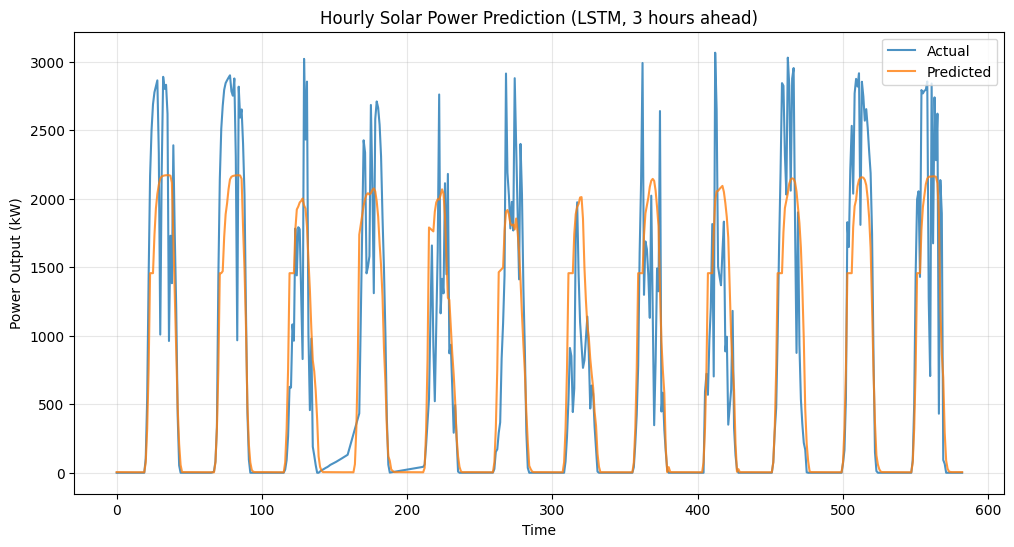

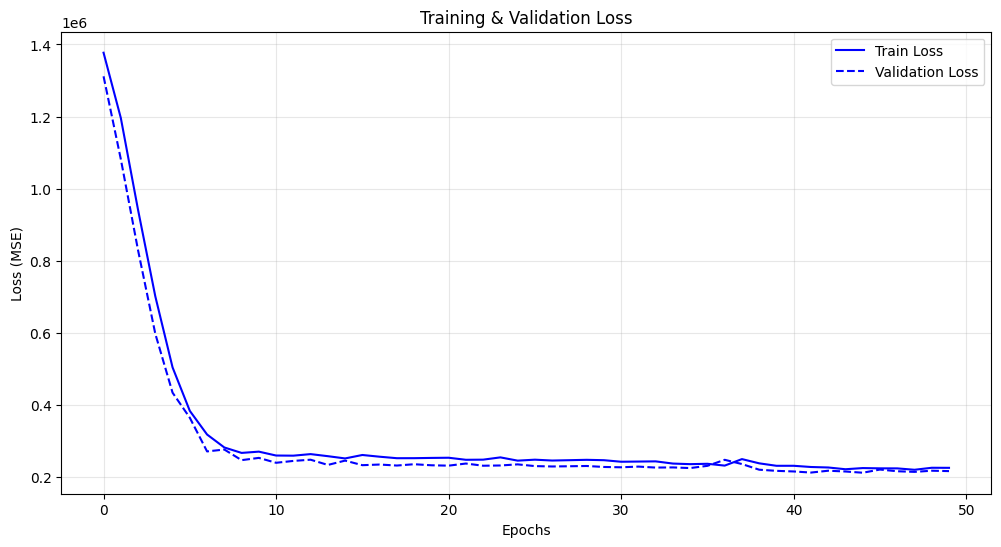

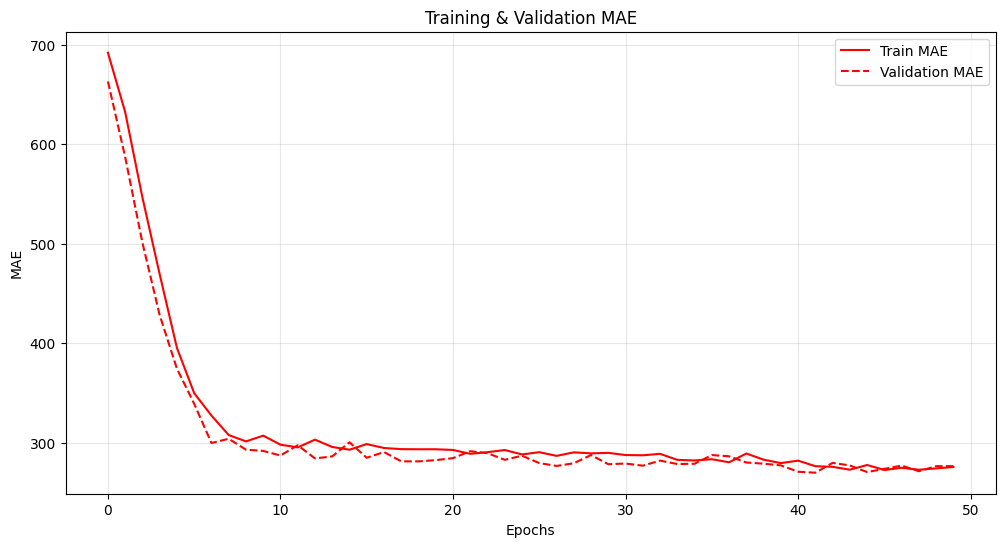

{'rmse': np.float64(460.6950337642944),
 'mae': 270.78143467835883,
 'r2': 0.7753307815930265}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
class LSTMForecastModel:
    def __init__(self, data=None, file_path=None, lookback=10): # lookback is how many rows back in the data the model is seeing. you will need to adjust this if you
                                                              # adjsut how you resample the data (I commented on this below in the preprocess data method)
        """
        Initialize the LSTM model with either a DataFrame or a CSV file path.
        Parameters:
        - data: pandas DataFrame containing the input data.
        - file_path: path to the CSV file containing the data.
        - lookback: Number of past timesteps to use as input for LSTM.
        """
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Either a DataFrame or a file path must be provided.")
        self.lookback = lookback  # Number of time steps for input sequences
        self.scaler = StandardScaler()
        self.features = [
            'total_output_power_kW', 'average_temperature_C', 'WMS 01 irradiance', 'hours_since_sunrise'#,'hours_until_sunset',
      #       'total_last_active_fault', 'total_net_AC_voltage_V','total_time_run_today_h', 'average_average_cosphii_percent',
      #  'total_DC_voltage_DCV', 'total_output_current_A',
      #  'total_grid_connections','total_net_frequency_Hz'
        ]# is_daytime
        '''
       for self.features you can add more columns to this if you want. but these are some of the ones that i have been using.
        '''
    def preprocess_data(self):
      """Preprocess the dataset for LSTM input."""
      if 'datetime' in self.df.columns:
          self.df['datetime'] = pd.to_datetime(self.df['datetime'])
          self.df.set_index('datetime', inplace=True)
      elif 'index' in self.df.columns:
          self.df['datetime'] = pd.to_datetime(self.df['index'])
          self.df.set_index('datetime', inplace=True)

      self.df['hour'] = self.df.index.hour
      self.df['minute'] = self.df.index.minute

      # Time since sunrise (assumed 6 AM)
      self.df['hours_since_sunrise'] = self.df['hour'] + self.df['minute'] / 60 - 6
      self.df['hours_since_sunrise'] = self.df['hours_since_sunrise'].apply(lambda x: max(0, x))

      # Time until sunset (assumed 8 PM)
      self.df['hours_until_sunset'] = 18 - (self.df['hour'] + self.df['minute'] / 60)
      self.df['hours_until_sunset'] = self.df['hours_until_sunset'].apply(lambda x: max(0, x))

      # Is daytime (06:00-18:00)
      self.df['is_daytime'] = ((self.df['hour'] >= 6) & (self.df['hour'] < 18)).astype(int)

      # Keep the original data frequency (no resampling)
      df_processed = self.df

      # Calculate the number of rows that represent 3 hours
      # First, determine the time interval between consecutive rows
      time_diff = (self.df.index[1] - self.df.index[0]).total_seconds() / 60  # in minutes

      # Calculate how many rows represent 3 hours
      # 3 hours = 180 minutes
      rows_for_3_hours = int(180 / time_diff)

      # Target variable (predict power exactly 3 hours ahead)
      df_processed['power_future'] = df_processed['total_output_power_kW'].shift(-rows_for_3_hours)

      self.df_clean = df_processed.dropna()
      self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])

    def create_sequences(self):
        """Convert the dataframe into sequences for LSTM input."""
        X, y = [], []
        data = self.df_clean[self.features].values
        target = self.df_clean['power_future'].values
        for i in range(len(data) - self.lookback):
            X.append(data[i:i + self.lookback])
            y.append(target[i + self.lookback])
        self.X = np.array(X)
        self.y = np.array(y)

        # Train-test split (80% train, 20% test)
        split_idx = int(len(self.X) * 0.8)
        self.X_train, self.X_test = self.X[:split_idx], self.X[split_idx:]
        self.y_train, self.y_test = self.y[:split_idx], self.y[split_idx:]
    def build_model(self):
        """Define the LSTM model architecture."""
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=(self.lookback, len(self.features))),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.model = model
    def train_model(self, epochs=50, batch_size=16):
        """Train the LSTM model and store history for plotting."""
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        self.history = self.model.fit(
            self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
            validation_data=(self.X_test, self.y_test), verbose=1, callbacks=[early_stopping]
        )
    def evaluate_model(self):
        """Evaluate the LSTM model on the test set."""
        y_pred = self.model.predict(self.X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)  # for non-negative predictions
        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }
        return self.metrics
    def plot_results(self):
        """Plot actual vs predicted power output."""
        y_pred = self.model.predict(self.X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test, label='Actual', alpha=0.8)
        plt.plot(y_pred, label='Predicted', alpha=0.8)
        plt.title('Hourly Solar Power Prediction (LSTM, 3 hours ahead)')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    def plot_training_history(self):
        """Plot training & validation loss and MAE."""
        fig, ax1 = plt.subplots(figsize=(12, 6))
        # Plot loss
        ax1.plot(self.history.history['loss'], label='Train Loss', color='blue')
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss (MSE)')
        ax1.set_title('Training & Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        plt.show()
        # Plot MAE
        fig, ax2 = plt.subplots(figsize=(12, 6))
        ax2.plot(self.history.history['mae'], label='Train MAE', color='red')
        ax2.plot(self.history.history['val_mae'], label='Validation MAE', color='red', linestyle='dashed')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('MAE')
        ax2.set_title('Training & Validation MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        plt.show()
    def run_pipeline(self, epochs=50, batch_size=16):
        """Run the full pipeline: preprocessing, sequence creation, training, evaluating, and plotting."""
        self.preprocess_data()
        self.create_sequences()
        self.build_model()
        self.train_model(epochs=epochs, batch_size=batch_size)
        results = self.evaluate_model()
        self.plot_results()
        self.plot_training_history()
        return results

model = LSTMForecastModel(data= df)
results = model.run_pipeline()
results

In [ ]:
{'rmse': np.float64(445.51168058954084),
 'mae': 265.1094353396486,
 'r2': 0.7851700159283027}

Index(['Unnamed: 0', 'datetime', 'average_temperature_C',
       'total_net_AC_voltage_V', 'total_time_run_total_h',
       'total_todays_energy_kWh', 'total_Export Energy',
       'total_last_active_fault', 'total_yesterdays_energy_kWh',
       'average_average_cosphii_percent', 'total_Accumulated Export Energy',
       'total_output_current_A', 'total_output_power_kW',
       'total_time_run_today_h', 'total_time_run_yesterday_h',
       'total_energy_counter_MWh', 'total_DC_voltage_DCV',
       'total_net_frequency_Hz', 'total_grid_connections',
       'WMS 01 ambient_temperature', 'WMS 01 irradiance', 'WMS 01 wind_speed',
       'hour'],
      dtype='object')

### you can use the following code if you want but this was just something i was messing around with. I was trying to do it a differnt way but i was getting pretty much the same results.

Preprocessing data...
Creating sequences...
Training data shapes: Historical=(4675, 6, 5), Current=(4675, 5)
Building model...


<ipython-input-14-48e4f95e6ed7>:74: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = self.df.resample('15T').mean()
<ipython-input-14-48e4f95e6ed7>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.historical_features] = self.historical_scaler.fit_transform(
<ipython-input-14-48e4f95e6ed7>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.current_features] = self.current_scaler.fit_transform(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ historical_input          │ (None, 6, 5)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ current_input             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 6, 128)         │         68,608 │ historical_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 128)            │            768 │ current_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 6, 128)         │              0 │ lstm_14[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 64)             │          8,256 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 64)             │         49,408 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 64)             │          4,160 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 64)             │              0 │ lstm_15[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 64)             │              0 │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128)            │              0 │ dropout_22[0][0],      │
│ (Concatenate)             │                        │                │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 36)             │          4,644 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1)              │             37 │ dense_38[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 135,881 (530.79 KB)

 Trainable params: 135,881 (530.79 KB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 1007714.9375 - mae: 576.6868 - val_loss: 307785.7188 - val_mae: 349.5176
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 288345.3750 - mae: 337.0964 - val_loss: 240791.6250 - val_mae: 314.3649
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 225062.2031 - mae: 283.7431 - val_loss: 197169.7812 - val_mae: 247.5738
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 216855.1562 - mae: 271.4585 - val_loss: 186438.2969 - val_mae: 238.8062
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 210880.5000 - mae: 259.7795 - val_loss: 175524.1406 - val_mae: 230.9981
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 195856.9219 - mae: 248.9612 - val_loss: 213282.1875 - val_mae: 270.3454
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 210040.7656 - mae: 266.6983 - val_loss: 176574.8438 - val_mae: 246.1673
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

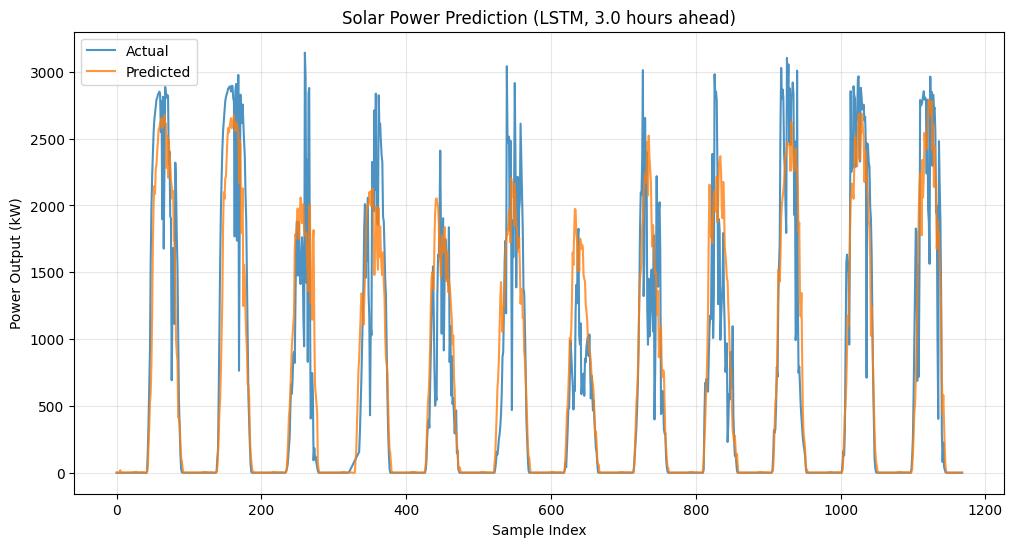

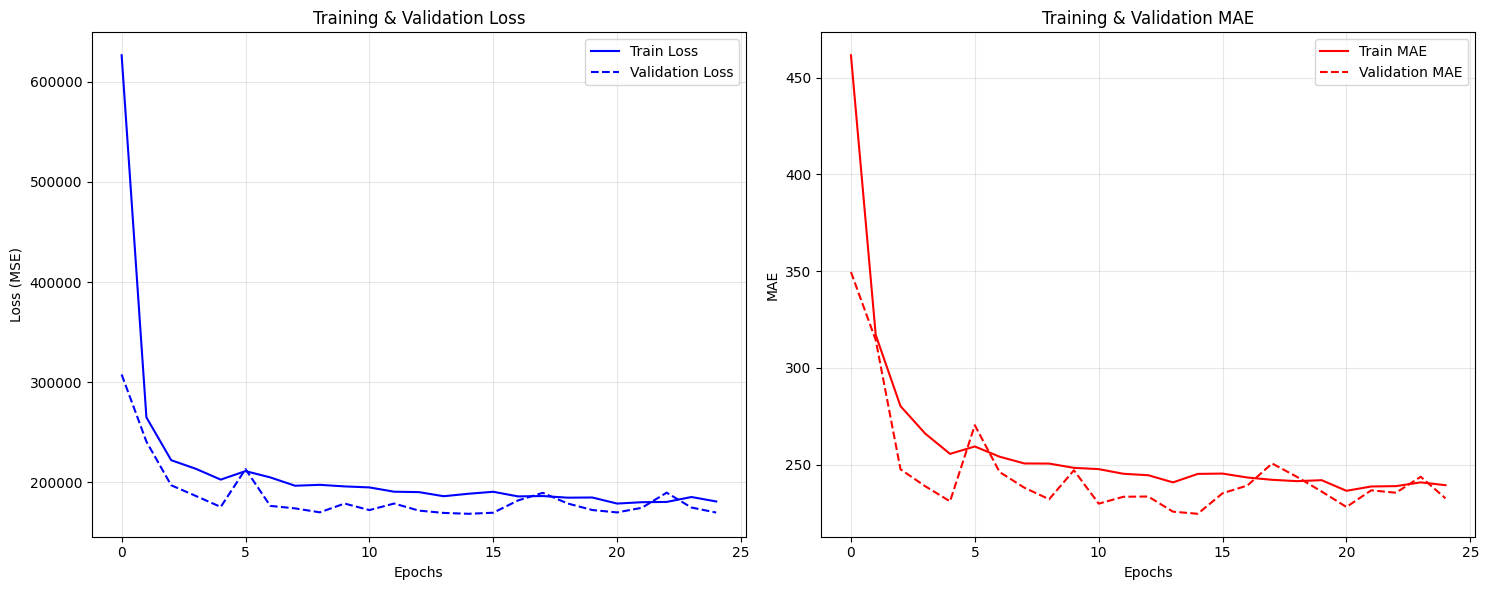

{'rmse': np.float64(410.69655876309986),
 'mae': 224.39199149443718,
 'r2': 0.8192188995927701}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ImprovedLSTMForecastModel:
    def __init__(self, data=None, file_path=None, lookback=6, forecast_horizon=3):

        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Either a DataFrame or a file path must be provided.")

        self.lookback = lookback
        self.forecast_horizon = forecast_horizon

        # Separate features into historical and current categories
        self.historical_features = [
            'total_output_power_kW',
            'WMS 01 ambient_temperature',
            'hours_since_sunrise',
            'hours_until_sunset',
            'is_daytime'
        ]

        # Features available at prediction time
        self.current_features = [
            'hour',
            'minute',
            'WMS 01 irradiance',
            'hours_since_sunrise',
            'hours_until_sunset'
        ]
      # scale for each group
        self.historical_scaler = StandardScaler()
        self.current_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

    def preprocess_data(self):
        """Preprocess the dataset for LSTM input."""
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        self.df['hour'] = self.df.index.hour
        self.df['minute'] = self.df.index.minute

        self.df['hours_since_sunrise'] = self.df['hour'] + self.df['minute'] / 60 - 6
        self.df['hours_since_sunrise'] = self.df['hours_since_sunrise'].apply(lambda x: max(0, x))

        self.df['hours_until_sunset'] = 18 - (self.df['hour'] + self.df['minute'] / 60)
        self.df['hours_until_sunset'] = self.df['hours_until_sunset'].apply(lambda x: max(0, x))

        self.df['is_daytime'] = ((self.df['hour'] >= 6) & (self.df['hour'] < 18)).astype(int)


        df_resampled = self.df.resample('15T').mean()

        df_resampled['power_future'] = df_resampled['total_output_power_kW'].shift(-self.forecast_horizon)

        self.df_clean = df_resampled.dropna()

        self.df_clean[self.historical_features] = self.historical_scaler.fit_transform(
            self.df_clean[self.historical_features]
        )

        self.df_clean[self.current_features] = self.current_scaler.fit_transform(
            self.df_clean[self.current_features]
        )

        target_values = self.df_clean[['power_future']].values
        self.target_scaler.fit(target_values)

    def create_sequences(self):
        """
        Create two types of sequences:
        1. Historical sequences for lagged features
        2. Current values for features available at prediction time
        """
        X_hist, X_curr, y = [], [], []

        hist_data = self.df_clean[self.historical_features].values
        curr_data = self.df_clean[self.current_features].values
        target_data = self.df_clean['power_future'].values

        for i in range(len(self.df_clean) - self.lookback):
            X_hist.append(hist_data[i:i + self.lookback])


            X_curr.append(curr_data[i + self.lookback])

            y.append(target_data[i + self.lookback])

        self.X_hist = np.array(X_hist)
        self.X_curr = np.array(X_curr)
        self.y = np.array(y)

        # Train-test split (80% train, 20% test)
        split_idx = int(len(self.X_hist) * 0.8)

        self.X_hist_train = self.X_hist[:split_idx]
        self.X_hist_test = self.X_hist[split_idx:]

        self.X_curr_train = self.X_curr[:split_idx]
        self.X_curr_test = self.X_curr[split_idx:]

        self.y_train = self.y[:split_idx]
        self.y_test = self.y[split_idx:]

        print(f"Training data shapes: Historical={self.X_hist_train.shape}, Current={self.X_curr_train.shape}")

    def build_model(self):
        """Build a model that handles both historical and current features."""
        hist_input = Input(shape=(self.lookback, len(self.historical_features)), name='historical_input')

        # Process historical features
        lstm_out = LSTM(128, activation='relu', return_sequences=True)(hist_input)
        lstm_out = Dropout(0.2)(lstm_out)
        lstm_out = LSTM(64, activation='relu')(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)

        # Input for current features
        curr_input = Input(shape=(len(self.current_features),), name='current_input')
        curr_dense = Dense(128, activation='relu')(curr_input)
        curr_dense = Dense(64, activation='relu')(curr_dense)
        curr_dense = Dense(64, activation='relu')(curr_dense)


        curr_dense = Dropout(0.1)(curr_dense)

        # Combine both
        combined = Concatenate()([lstm_out, curr_dense])

        #  dense layers
        dense = Dense(36, activation='relu')(combined)
        output = Dense(1)(dense)

        # model with tow inputs
        model = Model(inputs=[hist_input, curr_input], outputs=output)

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        model.summary()

        self.model = model

    def train_model(self, epochs=50, batch_size=16):
        """Train the model with two input branches."""
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        self.history = self.model.fit(
            [self.X_hist_train, self.X_curr_train],
            self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([self.X_hist_test, self.X_curr_test], self.y_test),
            verbose=1,
            callbacks=[early_stopping]
        )

    def evaluate_model(self):
        """Evaluate the model on test data."""
        y_pred = self.model.predict([self.X_hist_test, self.X_curr_test])
        y_pred = np.clip(y_pred, a_min=0, a_max=None)  #  non-negative predictions

        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }

        return self.metrics

    def plot_results(self):
        """Plot actual vs predicted power output."""
        y_pred = self.model.predict([self.X_hist_test, self.X_curr_test])
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test, label='Actual', alpha=0.8)
        plt.plot(y_pred, label='Predicted', alpha=0.8)
        plt.title(f'Solar Power Prediction (LSTM, {self.forecast_horizon/2} hours ahead)')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Sample Index')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_training_history(self):
        """Plot training & validation loss and MAE."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot loss
        ax1.plot(self.history.history['loss'], label='Train Loss', color='blue')
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss (MSE)')
        ax1.set_title('Training & Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot MAE
        ax2.plot(self.history.history['mae'], label='Train MAE', color='red')
        ax2.plot(self.history.history['val_mae'], label='Validation MAE', color='red', linestyle='dashed')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('MAE')
        ax2.set_title('Training & Validation MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


    def run_pipeline(self, epochs=100, batch_size=32):
        """Run the full model pipeline."""
        print("Preprocessing data...")
        self.preprocess_data()

        print("Creating sequences...")
        self.create_sequences()

        print("Building model...")
        self.build_model()

        print("Training model...")
        self.train_model(epochs=epochs, batch_size=batch_size)

        print("Evaluating model...")
        results = self.evaluate_model()
        print(f"Results: RMSE={results['rmse']:.4f}, MAE={results['mae']:.4f}, R²={results['r2']:.4f}")

        self.plot_results()
        self.plot_training_history()

        return results

# Usage example:
model = ImprovedLSTMForecastModel(data=df, forecast_horizon=6)
results = model.run_pipeline()
results

In [ ]:
results

{'rmse': np.float64(410.69655876309986),
 'mae': 224.39199149443718,
 'r2': 0.8192188995927701}

In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'average_temperature_C',
       'total_net_AC_voltage_V', 'total_time_run_total_h',
       'total_todays_energy_kWh', 'total_Export Energy',
       'total_last_active_fault', 'total_yesterdays_energy_kWh',
       'average_average_cosphii_percent', 'total_Accumulated Export Energy',
       'total_output_current_A', 'total_output_power_kW',
       'total_time_run_today_h', 'total_time_run_yesterday_h',
       'total_energy_counter_MWh', 'total_DC_voltage_DCV',
       'total_net_frequency_Hz', 'total_grid_connections',
       'WMS 01 ambient_temperature', 'WMS 01 irradiance', 'WMS 01 wind_speed',
       'hour'],
      dtype='object')

# XGBoost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

class XGBoostModel:
    def __init__(self, data=None, file_path=None):
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Provide either a DataFrame or file path")

        self.scaler = MinMaxScaler()
        self.model = None  # Will be set after grid search
        self.features = ['WMS 01 irradiance','hours_since_sunrise','hours_until_sunset', 'is_daytime']

        # Define what features to engineer and how
        self.feature_engineering_plan = {
            'total_output_power_kW': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'average_temperature_C': {'lags': [3, 6], 'rolling': {'mean': [3]}},
           'total_DC_voltage_DCV':{'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'total_output_current_A': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'average_average_cosphii_percent': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'total_time_run_today_h': {'lags': [3, 6], 'rolling': {'sum': [3, 6]}},
            'total_last_active_fault': {'lags': [3], 'rolling': {'sum': [3]}}
        }

    def preprocess_data(self):
        # Parse datetime
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        self.df['hour'] = self.df.index.hour
        self.df['minute'] = self.df.index.minute

        self.df['hours_since_sunrise'] = (self.df['hour'] + self.df['minute'] / 60 - 5).clip(lower=0)
        self.df['hours_until_sunset'] = (19 - (self.df['hour'] + self.df['minute'] / 60)).clip(lower=0)
        self.df['is_daytime'] = ((self.df['hour'] >= 5) & (self.df['hour'] < 19)).astype(int)

        # Resample to hourly mean
        df_hourly = self.df #self.df.resample('90T').mean()

        # Feature engineering
        for col, ops in self.feature_engineering_plan.items():
            if 'lags' in ops:
                for lag in ops['lags']:
                    feature_name = f'{col}_lag_{lag}'
                    df_hourly[feature_name] = df_hourly[col].shift(lag)
                    self.features.append(feature_name)
            if 'rolling' in ops:
                for method, windows in ops['rolling'].items():
                    for window in windows:
                        feature_name = f'{col}_{method}_{window}'
                        if method == 'mean':
                            df_hourly[feature_name] = df_hourly[col].rolling(window=window).mean()
                        elif method == 'sum':
                            df_hourly[feature_name] = df_hourly[col].rolling(window=window).sum()
                        self.features.append(feature_name)

        # Add time-based features
        time_features = ['hour', 'hours_since_sunrise', 'hours_until_sunset', 'is_daytime']
        df_hourly[time_features] = self.df[time_features]
        self.features += time_features

        # Create target (3-hour ahead forecast)
        df_hourly['power_future'] = df_hourly['total_output_power_kW'].shift(-1)

        # Final clean dataset
        self.df_clean = df_hourly.dropna()

    def train_model(self):
        print(self.features)
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        param_grid = {
            'n_estimators': [100, 150, 200],         # Number of trees
            'max_depth': [3, 5, 7],                # Tree depth
            'learning_rate': [0.05, 0.1],       # Learning rate
            'subsample': [0.8, 1.0],            # Sample rate per tree
            'colsample_bytree': [0.8, 1.0]      # Feature sample rate per tree
        }



        grid = GridSearchCV(
            XGBRegressor(objective='reg:squarederror', random_state=42),
            param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )

        grid.fit(self.X_train_scaled, self.y_train)
        self.model = grid.best_estimator_

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }

        return self.metrics

    def plot_results(self):
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.index, self.y_test.values, label='Actual')
        plt.plot(self.y_test.index, y_pred, label='Predicted')
        plt.title('3-Hour Ahead Solar Power Prediction')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        residuals = self.y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted')
        plt.ylabel('Residual')
        plt.grid(True)
        plt.show()

    def run_pipeline(self):
        self.preprocess_data()
        self.train_model()
        results = self.evaluate_model()
        self.plot_results()
        return results


['WMS 01 irradiance', 'hours_since_sunrise', 'hours_until_sunset', 'is_daytime', 'total_output_power_kW_lag_3', 'total_output_power_kW_lag_6', 'total_output_power_kW_mean_3', 'total_output_power_kW_mean_6', 'average_temperature_C_lag_3', 'average_temperature_C_lag_6', 'average_temperature_C_mean_3', 'total_DC_voltage_DCV_lag_3', 'total_DC_voltage_DCV_lag_6', 'total_DC_voltage_DCV_mean_3', 'total_DC_voltage_DCV_mean_6', 'total_output_current_A_lag_3', 'total_output_current_A_lag_6', 'total_output_current_A_mean_3', 'total_output_current_A_mean_6', 'average_average_cosphii_percent_lag_3', 'average_average_cosphii_percent_lag_6', 'average_average_cosphii_percent_mean_3', 'average_average_cosphii_percent_mean_6', 'total_time_run_today_h_lag_3', 'total_time_run_today_h_lag_6', 'total_time_run_today_h_sum_3', 'total_time_run_today_h_sum_6', 'total_last_active_fault_lag_3', 'total_last_active_fault_sum_3', 'hour', 'hours_since_sunrise', 'hours_until_sunset', 'is_daytime']
Fitting 3 folds for 

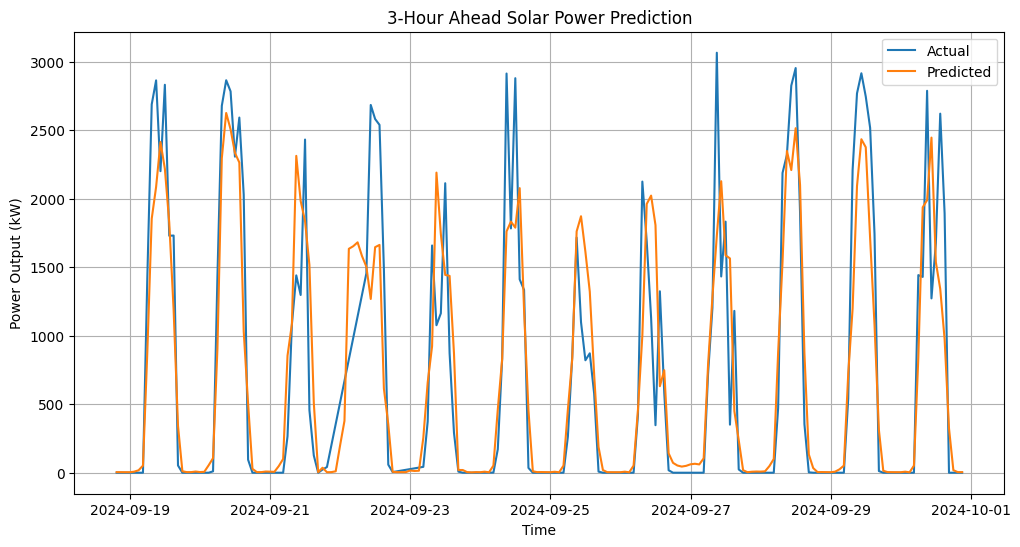

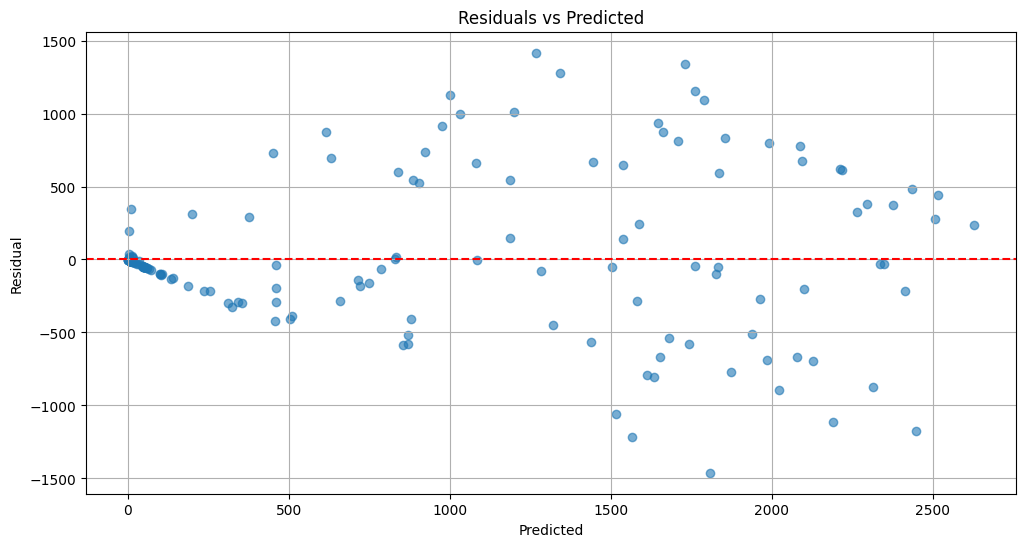

{'rmse': np.float64(459.5521142592569),
 'mae': 282.64282720358585,
 'r2': 0.777689426647626}

In [ ]:
boost = XGBoostModel(data=df)
boost.run_pipeline()

In [ ]:
{'rmse': np.float64(349.2585113490821),
 'mae': 213.17718395283467,
 'r2': 0.8558629382626138}

{'rmse': np.float64(349.2585113490821),
 'mae': 213.17718395283467,
 'r2': 0.8558629382626138}

Step 1: Preprocessing data...
Added direct feature: WMS 01 irradiance
Total features created: 99

Step 2: Analyzing features...


<ipython-input-71-0584e57b1514>:132: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()
<ipython-input-71-0584e57b1514>:136: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled['power_future'] = future_target.resample(resample_freq).first()
<ipython-input-71-0584e57b1514>:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']


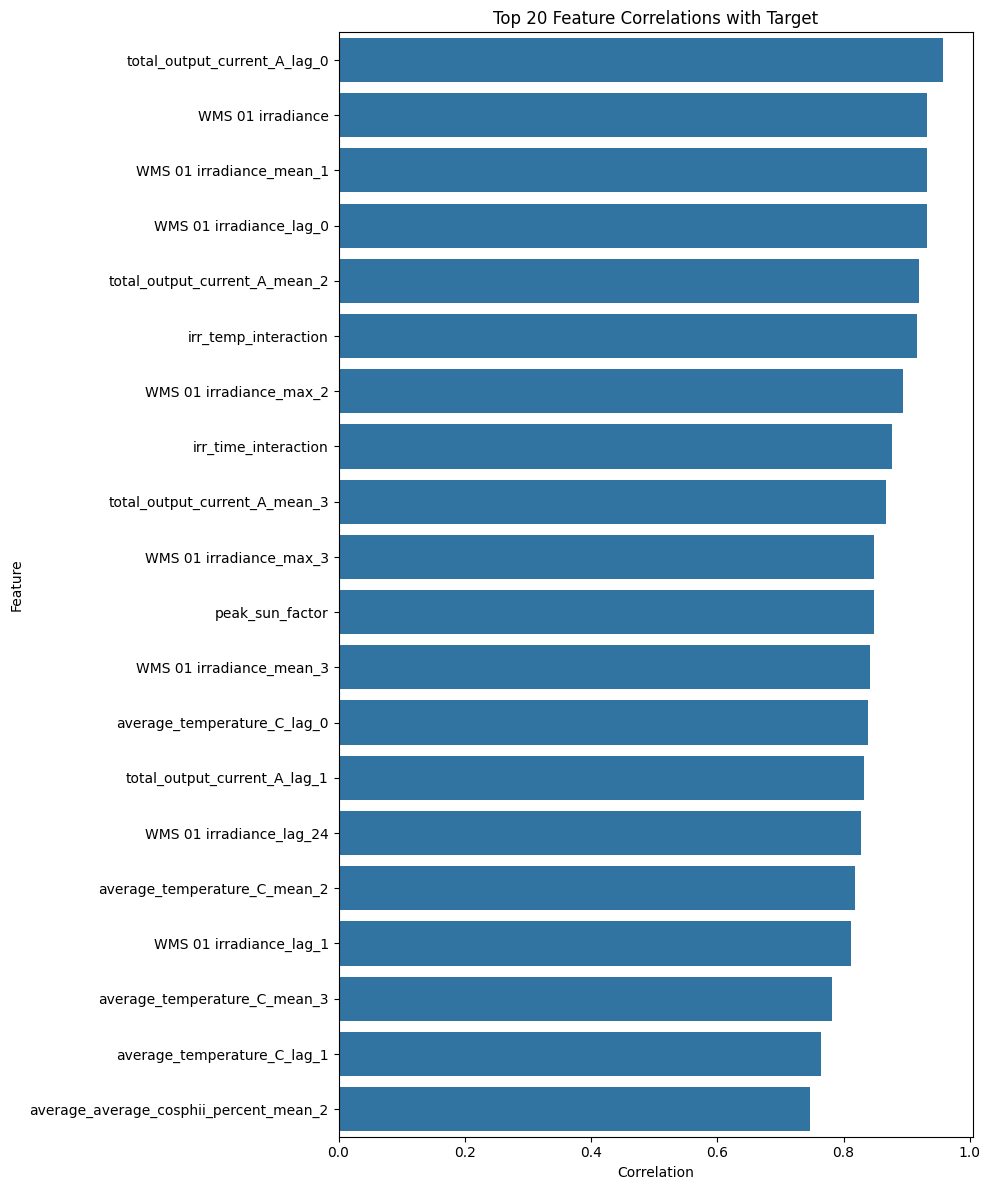

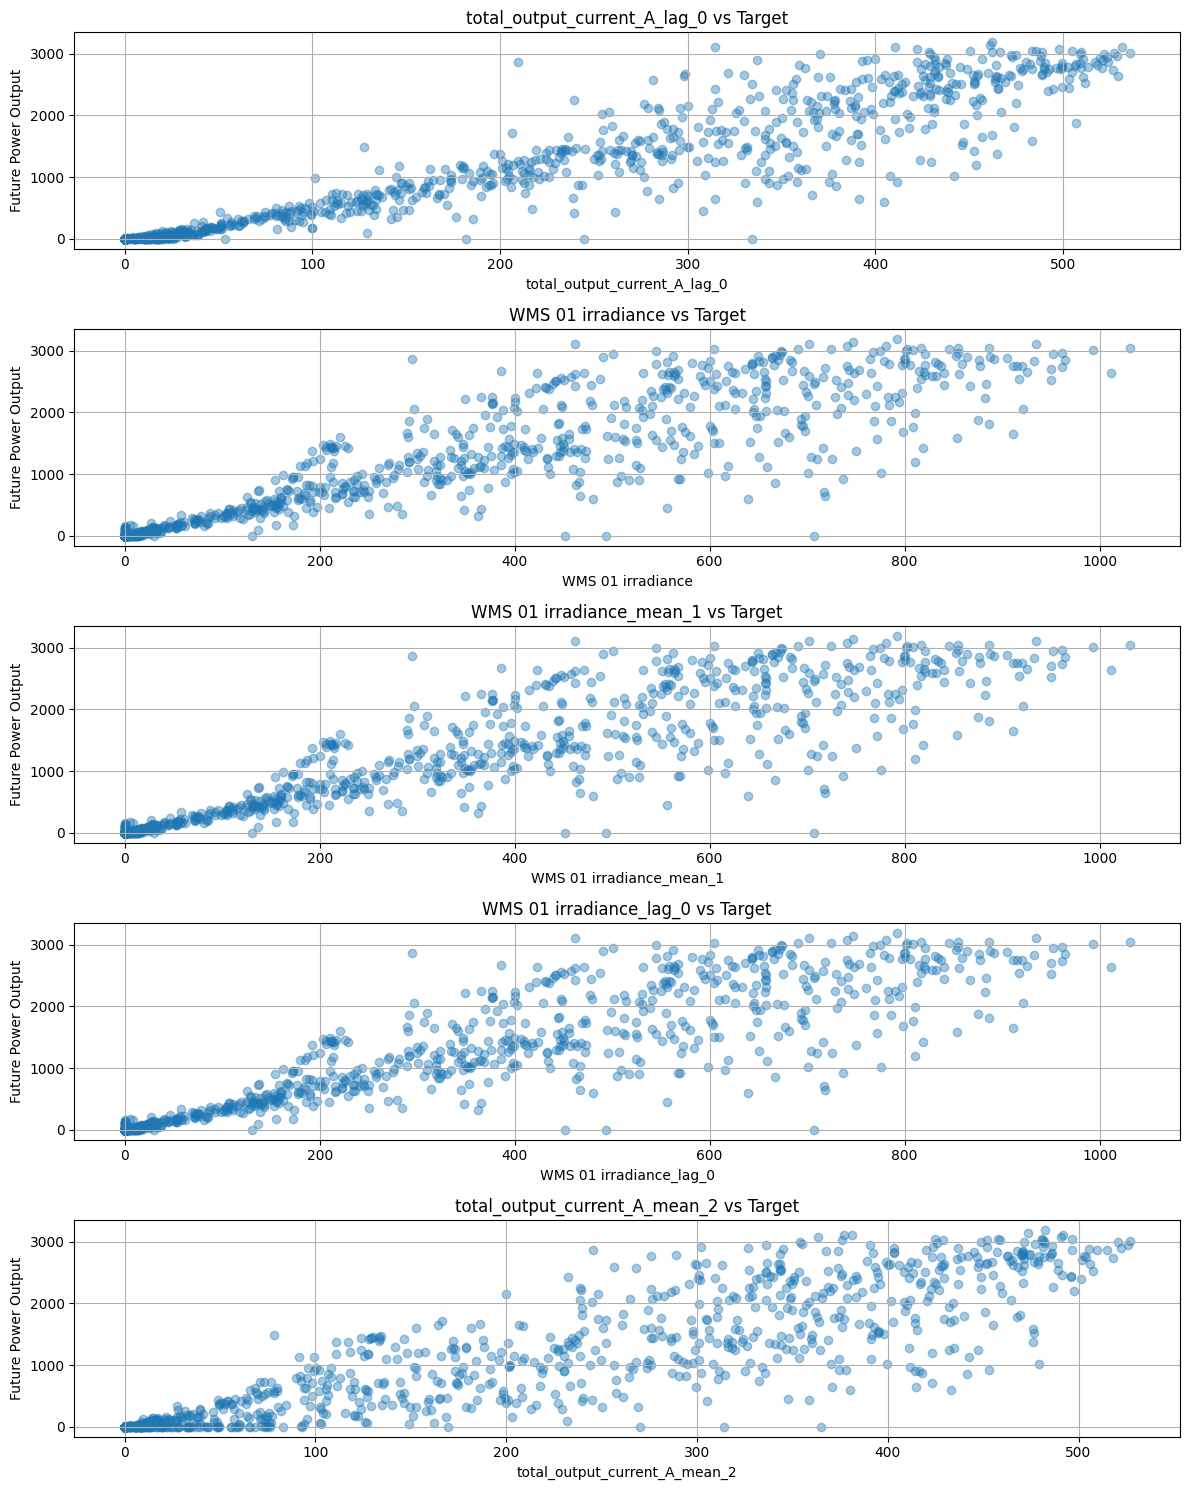


Step 3: Training model...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


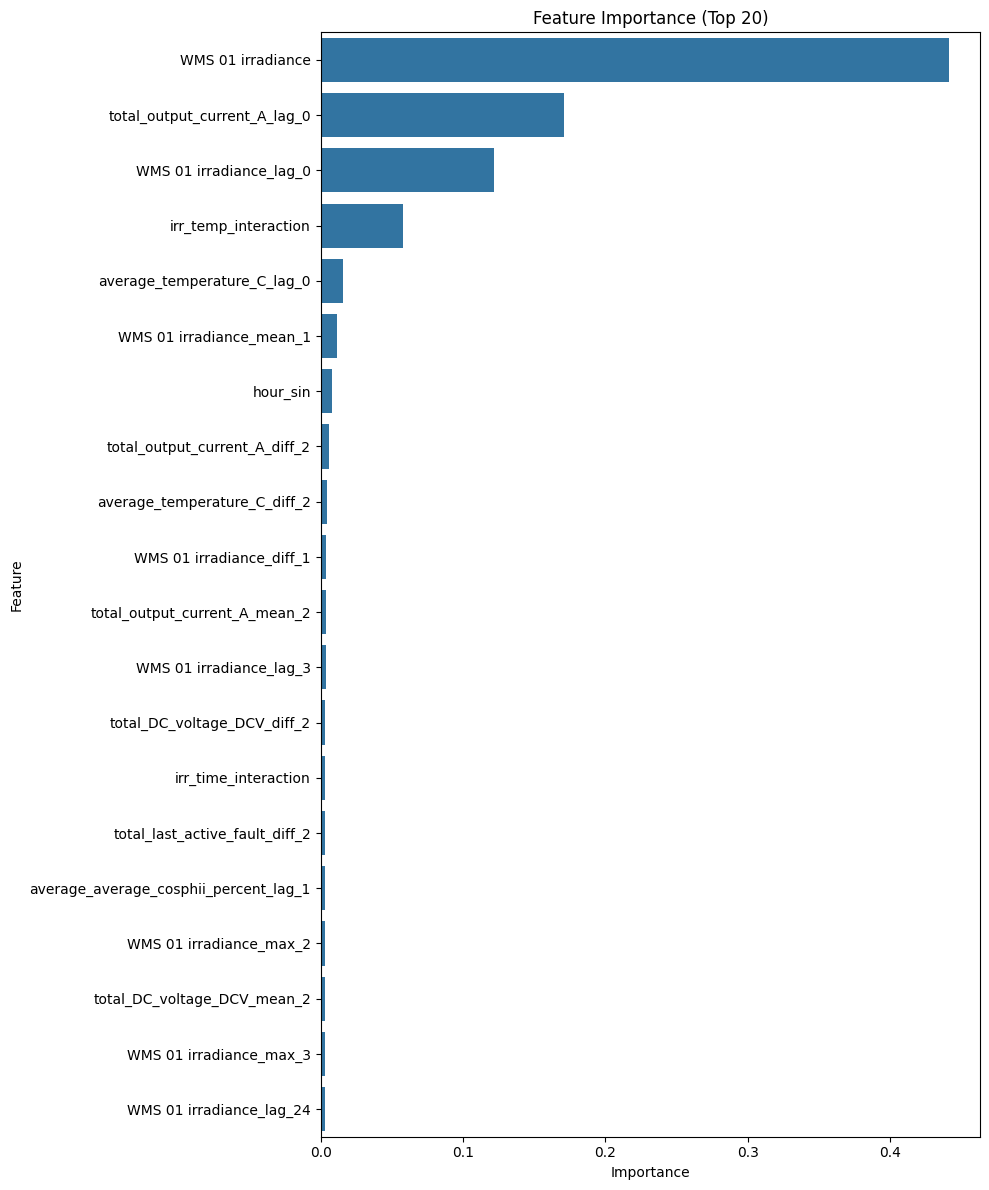


Step 4: Evaluating model...

Training Metrics:
RMSE: 98.2599
MAE: 61.4133
R2: 0.9894

Test Metrics:
RMSE: 293.1562
MAE: 160.7628
R2: 0.9114
NRMSE: 0.4133
NMAE: 0.2266

Step 5: Plotting results...


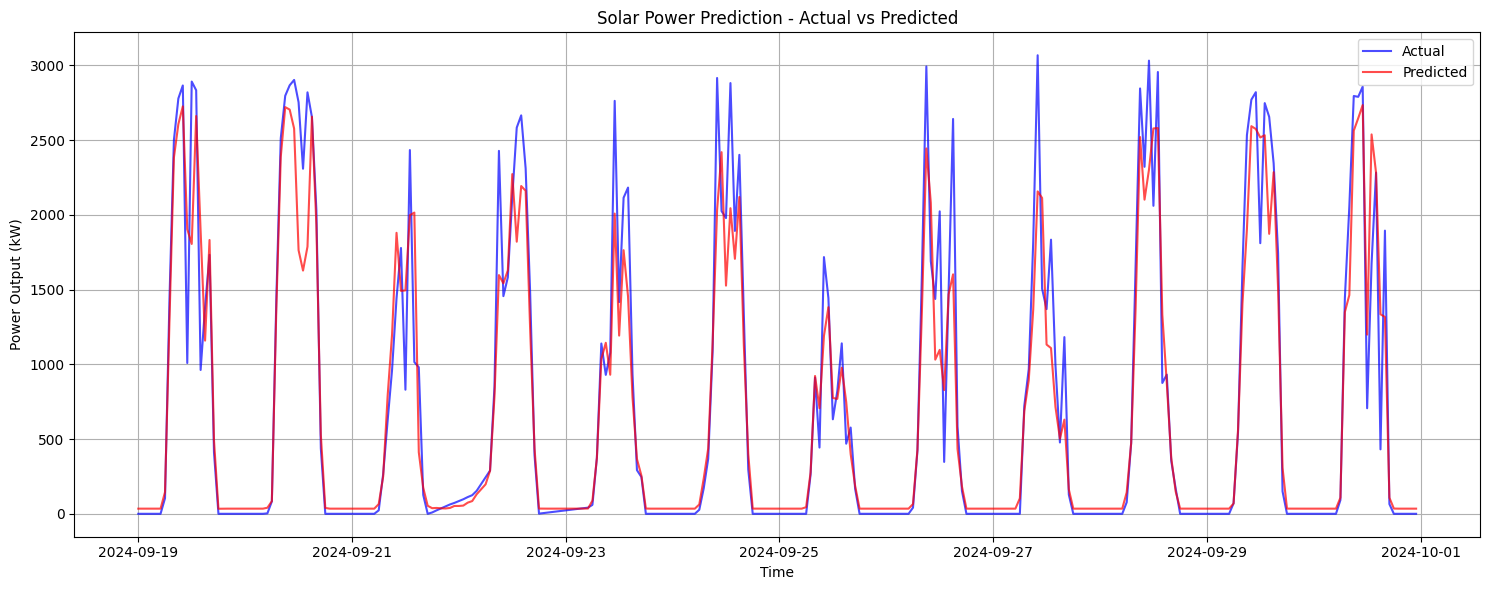

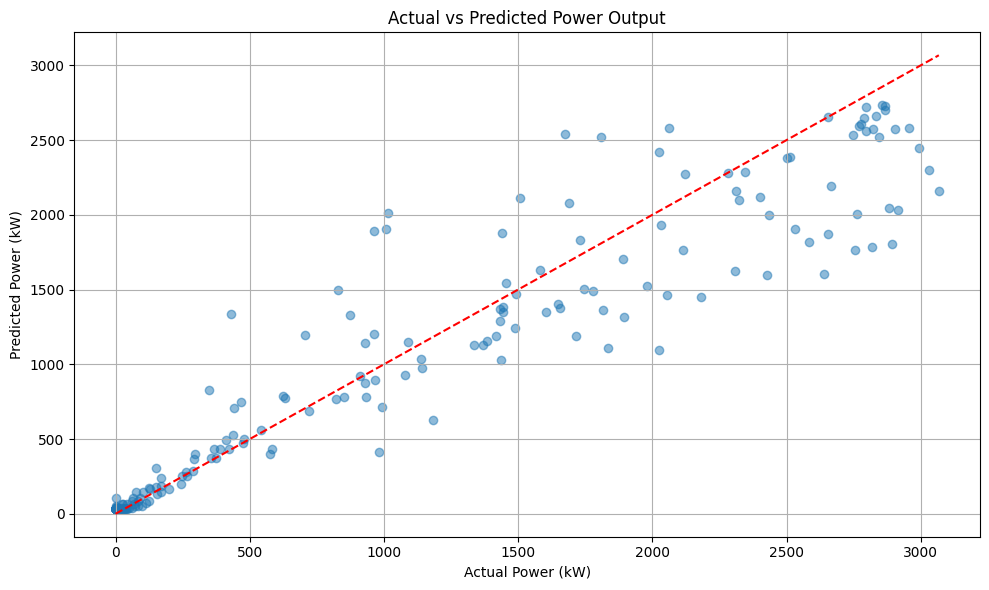

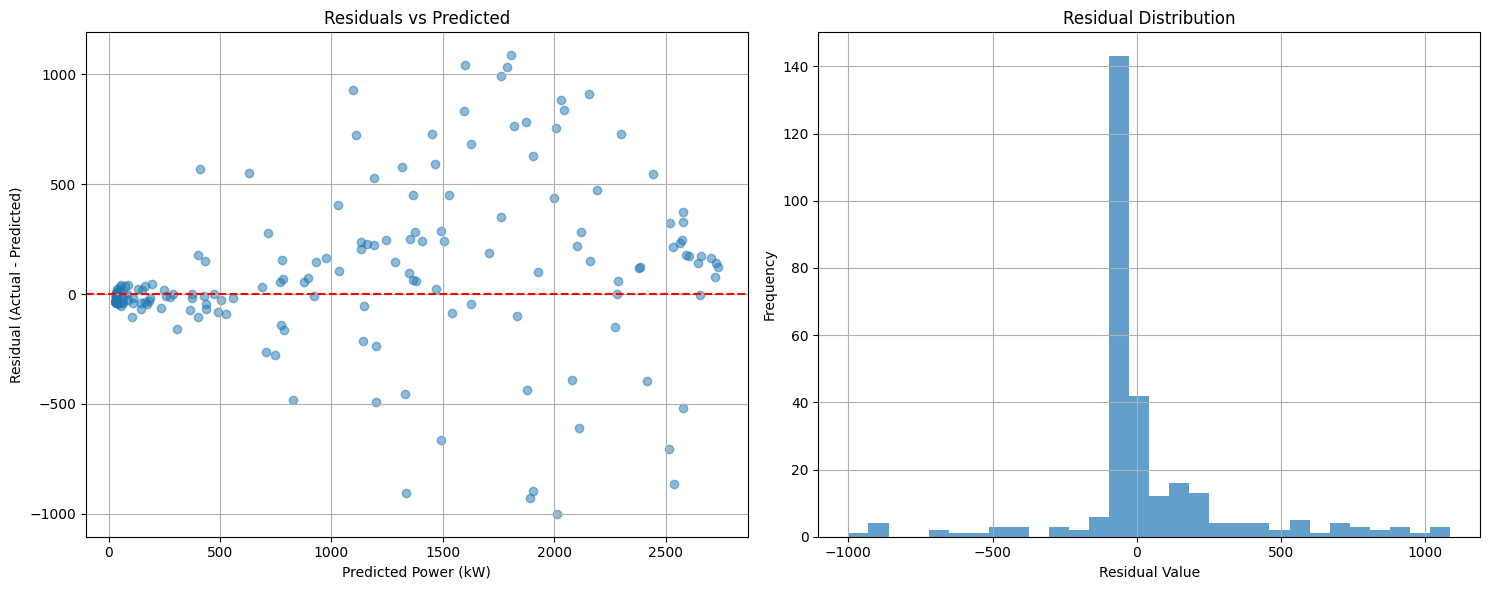

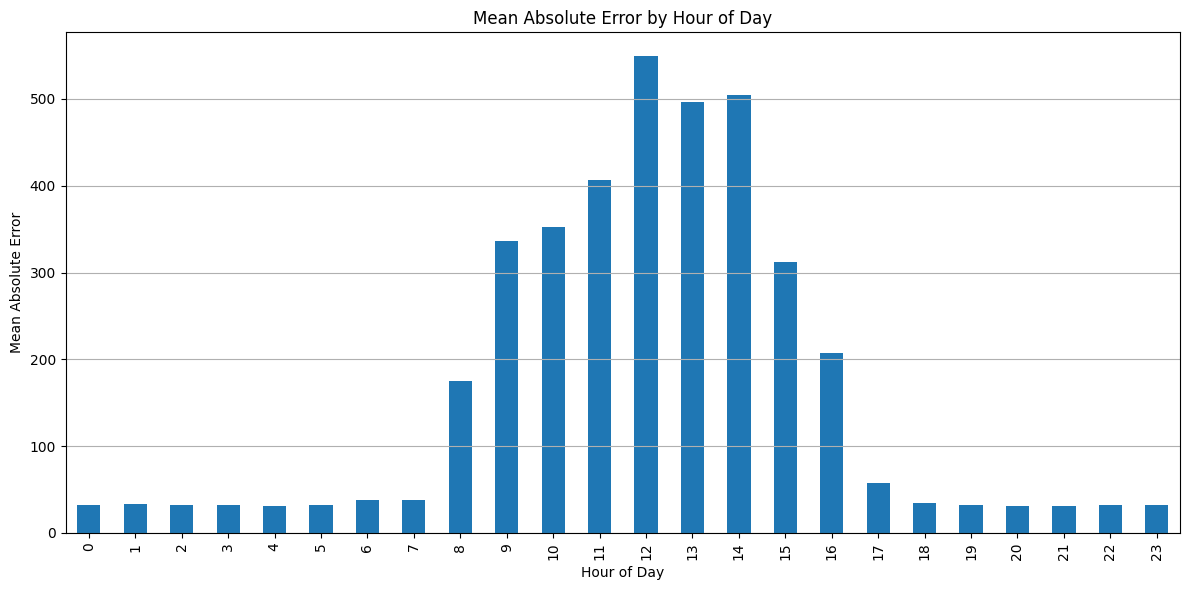

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns

class ImprovedXGBoostModel:
    def __init__(self, data=None, file_path=None, direct_features=None):
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Provide either a DataFrame or file path")

        # Allow user to specify which features to use directly
        self.direct_features = direct_features or ['WMS 01 irradiancee']

        self.scaler = MinMaxScaler()
        self.model = None

        # Starting with basic features
        self.features = []

        # Direct features to use (these are passed directly to the model without transformations)
        self.direct_features = ['WMS 01 irradiance']

        # Define what features to engineer and how
        self.feature_engineering_plan = {
            'total_output_power_kW': {
                'lags': [0,1, 2, 3, 6, 12, 24],  # Expanded lag windows
                'rolling': {'mean': [3, 6, 12], 'std': [3,6], 'min': [3,6], 'max': [2,3,6]},
                'diff': [1, 2,3]  # Rate of change in power
            },
            'average_temperature_C': {
                'lags': [0,1, 3, 6, 12],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]  # Temperature change rate
            },
            'total_DC_voltage_DCV': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]  # Voltage change rate
            },
            'total_output_current_A': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]
            },
            'average_average_cosphii_percent': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6]},
                'diff': [1, 2,3]
            },
            'total_time_run_today_h': {
                'lags': [0, 1, 3, 6],
                'rolling': {'sum': [3, 6]},
                'diff': [1, 2,3]
            },
            'total_last_active_fault': {
                'lags': [0, 1, 3],
                'rolling': {'sum': [3, 6]},
                'diff': [1, 2,3]
            }
        }

        # If solar irradiance is available, add it to plan
        if 'WMS 01 irradiance' in self.df.columns:
            self.feature_engineering_plan['WMS 01 irradiance'] = {
                'lags': [0, 1, 2, 3, 6, 12, 24],
                'rolling': {'mean': [1,3, 6, 12], 'std': [2,3,6], 'max': [2, 3,6]},
                'diff': [1, 2, 3]  # Rate of change in irradiance
            }

    def preprocess_data(self, target_horizon=3, resample_freq='60T'):
        """
        Preprocess data with more sophisticated feature engineering

        Parameters:
        - target_horizon: Number of periods ahead to predict
        - resample_freq: Frequency to resample data ('60T' for hourly)
        """
        # Parse datetime
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)
        else:
          # If no datetime column is found, try to infer from 'date' and 'time'
          try:
              self.df['datetime'] = pd.to_datetime(self.df['date'] + ' ' + self.df['time'])
              self.df.set_index('datetime', inplace=True)
          except KeyError:
              raise ValueError("No valid datetime information found. Please provide a 'datetime', 'date' and 'time', or 'index' column.")

        # Enhanced time-based features
        self.df['hour'] = self.df.index.hour
        self.df['day'] = self.df.index.day
        self.df['month'] = self.df.index.month
        self.df['dayofweek'] = self.df.index.dayofweek
        self.df['quarter'] = self.df.index.quarter
        self.df['minute'] = self.df.index.minute

        # Solar position-related features (improved)
        self.df['hours_since_sunrise'] = (self.df['hour'] + self.df['minute'] / 60 - 6).clip(lower=0)
        self.df['hours_until_sunset'] = (18 - (self.df['hour'] + self.df['minute'] / 60)).clip(lower=0)
        self.df['is_daytime'] = ((self.df['hour'] >= 6) & (self.df['hour'] < 18)).astype(int)

        # Peak sun hours approximation (simplified model)
        self.df['peak_sun_factor'] = np.sin(np.pi * (self.df['hour'] + self.df['minute']/60 - 6) / 12)
        self.df['peak_sun_factor'] = self.df['peak_sun_factor'].clip(lower=0)

        # Create cyclic time features to better capture periodicity
        self.df['hour_sin'] = np.sin(2 * np.pi * self.df['hour'] / 24)
        self.df['hour_cos'] = np.cos(2 * np.pi * self.df['hour'] / 24)
        self.df['month_sin'] = np.sin(2 * np.pi * self.df['month'] / 12)
        self.df['month_cos'] = np.cos(2 * np.pi * self.df['month'] / 12)

        # Resample to desired frequency
        # Step 1: Keep the original high-frequency target series
        original_target = self.df['total_output_power_kW'].copy()

        # Step 2: Resample all numeric feature columns except the target
        df_features = self.df.drop(columns=['total_output_power_kW'])
        df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()

        # Step 3: Rebuild target: get future values of original target aligned with the resampled timestamps
        future_target = original_target.shift(-target_horizon)
        df_resampled['power_future'] = future_target.resample(resample_freq).first()

        # Feature engineering based on plan
        for col, ops in self.feature_engineering_plan.items():
            if col not in df_resampled.columns:
                print(f"Warning: {col} not found in dataframe, skipping")
                continue

            # Create lag features
            if 'lags' in ops:
                for lag in ops['lags']:
                    feature_name = f'{col}_lag_{lag}'
                    df_resampled[feature_name] = df_resampled[col].shift(lag)
                    self.features.append(feature_name)

            # Create rolling window features
            if 'rolling' in ops:
                for method, windows in ops['rolling'].items():
                    for window in windows:
                        feature_name = f'{col}_{method}_{window}'
                        if method == 'mean':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).mean()
                        elif method == 'sum':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).sum()
                        elif method == 'std':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).std()
                        elif method == 'min':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).min()
                        elif method == 'max':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).max()
                        self.features.append(feature_name)

            # Create difference features (rate of change)
            if 'diff' in ops:
                for periods in ops['diff']:
                    feature_name = f'{col}_diff_{periods}'
                    df_resampled[feature_name] = df_resampled[col].diff(periods=periods)
                    self.features.append(feature_name)

        # Add time features to feature list
        time_features = ['hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                         'hours_since_sunrise', 'hours_until_sunset', 'is_daytime',
                         'peak_sun_factor']

        df_resampled[time_features] = self.df[time_features]
        self.features += time_features

        # Create interaction features if solar irradiance is available
        if 'WMS 01 irradiance' in df_resampled.columns:
            df_resampled['irr_temp_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['average_temperature_C']
            df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']
            self.features += ['irr_temp_interaction', 'irr_time_interaction']

        # Create target (future power output)
        #df_resampled['power_future'] = df_resampled['total_output_power_kW'].shift(-target_horizon)

        # Drop rows with NaN values
        self.df_clean = df_resampled.dropna()

        # Add direct features if they exist in the dataframe
        for feature in self.direct_features:
            if feature in df_resampled.columns:
                self.features.append(feature)
                print(f"Added direct feature: {feature}")

        # Print final feature list count
        print(f"Total features created: {len(self.features)}")

    def analyze_features(self):
        """Analyze feature importance and relationships"""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Correlation heatmap of top features with target
        corr = pd.DataFrame(X.corrwith(y).sort_values(ascending=False)).reset_index()
        corr.columns = ['Feature', 'Correlation']

        plt.figure(figsize=(10, 12))
        top_n = min(20, len(corr))
        sns.barplot(x='Correlation', y='Feature', data=corr.head(top_n))
        plt.title(f'Top {top_n} Feature Correlations with Target')
        plt.tight_layout()
        plt.show()

        # Plot relationship between top features and target
        top_features = corr.head(5)['Feature'].tolist()

        fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 15))
        for i, feature in enumerate(top_features):
            axes[i].scatter(X[feature], y, alpha=0.4)
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Future Power Output')
            axes[i].set_title(f'{feature} vs Target')
            axes[i].grid(True)

        plt.tight_layout()
        plt.show()

        return corr

    def train_model(self, param_grid=None):
        """Train XGBoost model with improved grid search"""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Train-test split with stratified temporal split
        split_idx = int(len(self.df_clean) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Default param grid if none provided
        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 7, 9],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2]
            }

        # Grid search with cross-validation
        grid = RandomizedSearchCV(
            XGBRegressor(objective='reg:squarederror', random_state=42),
            param_distributions=param_grid,
            n_iter=30,  # Try 20 random combinations
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )

        grid.fit(self.X_train_scaled, self.y_train)
        self.model = grid.best_estimator_

        print(f"Best parameters: {grid.best_params_}")

        # Get feature importance
        feature_importance = pd.DataFrame({
            'Feature': self.features,
            'Importance': self.model.feature_importances_
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 12))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Feature Importance (Top 20)')
        plt.tight_layout()
        plt.show()

        return feature_importance

    def evaluate_model(self):
        """Evaluate model with additional metrics"""
        # Make predictions
        y_pred_train = self.model.predict(self.X_train_scaled)
        y_pred_test = self.model.predict(self.X_test_scaled)

        # Clip negative predictions to zero
        y_pred_train = np.clip(y_pred_train, a_min=0, a_max=None)
        y_pred_test = np.clip(y_pred_test, a_min=0, a_max=None)

        # Calculate metrics
        train_metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_train, y_pred_train)),
            'mae': mean_absolute_error(self.y_train, y_pred_train),
            'r2': r2_score(self.y_train, y_pred_train)
        }

        test_metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred_test)),
            'mae': mean_absolute_error(self.y_test, y_pred_test),
            'r2': r2_score(self.y_test, y_pred_test)
        }

        # Calculate normalized metrics
        y_mean = self.y_test.mean()
        test_metrics['nrmse'] = test_metrics['rmse'] / y_mean
        test_metrics['nmae'] = test_metrics['mae'] / y_mean

        print("\nTraining Metrics:")
        for k, v in train_metrics.items():
            print(f"{k.upper()}: {v:.4f}")

        print("\nTest Metrics:")
        for k, v in test_metrics.items():
            print(f"{k.upper()}: {v:.4f}")

        self.metrics = test_metrics
        return train_metrics, test_metrics

    def plot_results(self):
        """Plot comprehensive evaluation results"""
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        # Create a DataFrame with actual and predicted values
        results_df = pd.DataFrame({
            'Actual': self.y_test.values,
            'Predicted': y_pred
        }, index=self.y_test.index)

        # Plot actual vs predicted time series
        plt.figure(figsize=(15, 6))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue', alpha=0.7)
        plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red', alpha=0.7)
        plt.title('Solar Power Prediction - Actual vs Predicted')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot scatter of actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)

        # Add perfect prediction line
        max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
        plt.plot([0, max_val], [0, max_val], 'r--')

        plt.title('Actual vs Predicted Power Output')
        plt.xlabel('Actual Power (kW)')
        plt.ylabel('Predicted Power (kW)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot residuals
        residuals = results_df['Actual'] - results_df['Predicted']
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(results_df['Predicted'], residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted Power (kW)')
        plt.ylabel('Residual (Actual - Predicted)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.title('Residual Distribution')
        plt.xlabel('Residual Value')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Plot predictions for a sample period (2 weeks)
        if len(results_df) > 14*24:  # If we have at least 2 weeks of data
            sample_period = results_df.iloc[-14*24:]  # Last 2 weeks

            plt.figure(figsize=(15, 6))
            plt.plot(sample_period.index, sample_period['Actual'], label='Actual', color='blue')
            plt.plot(sample_period.index, sample_period['Predicted'], label='Predicted', color='red')
            plt.title('2-Week Sample Period - Actual vs Predicted')
            plt.ylabel('Power Output (kW)')
            plt.xlabel('Time')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Display error over time of day
        results_df['hour'] = results_df.index.hour
        results_df['abs_error'] = abs(results_df['Actual'] - results_df['Predicted'])

        hour_error = results_df.groupby('hour')['abs_error'].mean()

        plt.figure(figsize=(12, 6))
        hour_error.plot(kind='bar')
        plt.title('Mean Absolute Error by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

    def test_for_leakage(self):
        """Leakage test: Train on shuffled targets and check performance"""

        # Shuffle the target values (break any true pattern)
        y_train_shuffled = np.random.permutation(self.y_train)

        # Train a new XGBoost model on the same features but with shuffled targets
        shuffled_model = XGBRegressor(objective='reg:squarederror', random_state=42)
        shuffled_model.fit(self.X_train_scaled, y_train_shuffled)

        # Predict on the test set
        y_pred_test = shuffled_model.predict(self.X_test_scaled)

        # Evaluate performance on real test targets
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
        mae = mean_absolute_error(self.y_test, y_pred_test)
        r2 = r2_score(self.y_test, y_pred_test)

        print("\n=== Leakage Detection Test ===")
        print("Model trained on SHUFFLED target values:")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R²: {r2:.4f}")

        if r2 > 0.2:
            print("⚠️ WARNING: Model is performing too well on shuffled data. Possible leakage!")
        else:
            print("✅ No obvious leakage detected.")

        return {'rmse': rmse, 'mae': mae, 'r2': r2}


    def run_pipeline(self, target_horizon=3, resample_freq='60T'):
        """Run the complete pipeline"""
        print("Step 1: Preprocessing data...")
        self.preprocess_data(target_horizon=target_horizon, resample_freq=resample_freq)

        print("\nStep 2: Analyzing features...")
        feature_corr = self.analyze_features()

        print("\nStep 3: Training model...")
        feature_importance = self.train_model()

        print("\nStep 4: Evaluating model...")
        train_metrics, test_metrics = self.evaluate_model()

        print("\nStep 5: Plotting results...")
        self.plot_results()

        return {
            'feature_correlation': feature_corr,
            'feature_importance': feature_importance,
            'metrics': test_metrics
        }

# Usage example
if __name__ == "__main__":
    # Example of how to use the model with solar irradiance as a direct feature

    # Option 1: Using default direct features (solar_irradiance)
    model = ImprovedXGBoostModel(data=df.reset_index())
    results = model.run_pipeline()
    # model.preprocess_data()
    # model.train_model()
    # model.test_for_leakage()
    # model.test_for_leakage()
    # # Option 2: Specify custom direct features
    # model = ImprovedXGBoostModel(
    #     file_path="your_solar_data.csv",
    #     direct_features=['solar_irradiance']
    # )
    # results = model.run_pipeline()

In [ ]:
df.columns

Index(['total_net_frequency_Hz', 'average_temperature_C',
       'total_yesterdays_energy_kWh', 'total_Accumulated Export Energy',
       'total_Export Energy', 'total_output_current_A',
       'total_output_power_kW', 'total_DC_voltage_DCV',
       'total_time_run_yesterday_h', 'total_grid_connections',
       'total_time_run_today_h', 'total_todays_energy_kWh',
       'total_net_AC_voltage_V', 'total_energy_counter_MWh',
       'total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent', 'WMS 01 ambient_temperature',
       'WMS 01 irradiance', 'WMS 01 wind_speed', 'hour'],
      dtype='object')

In [ ]:
'average_temperature_C', 'total_output_current_A','total_net_frequency_Hz', 'average_temperature_C',
                                     'total_output_current_A','total_output_power_kW', 'total_DC_voltage_DCV', 'total_net_AC_voltage_V','total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent'

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class SimpleForecastingModel:
    def __init__(self, df, target_col='total_output_power_kW', horizon_steps=6,
                 base_features=None, direct_features=None):
        self.df = df.copy()
        self.target_col = target_col
        self.horizon_steps = horizon_steps
        self.base_features = base_features or [
            'average_temperature_C','total_net_frequency_Hz', 'average_temperature_C',
                                     'total_output_current_A','total_output_power_kW', 'total_DC_voltage_DCV', 'total_net_AC_voltage_V','total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent'
        ]
        self.direct_features = direct_features or ['WMS 01 irradiance']
        self.scaler = MinMaxScaler()

    def create_features(self, lags=[1, 2, 3, 6], rolling_windows=[3, 6], diffs=[1, 2]):
        df = self.df

        df['target'] = df[self.target_col].shift(-self.horizon_steps)

        # Time-based features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

        # If minute is available, use it, else assume minute = 0
        if hasattr(df.index, 'minute'):
            minutes = df.index.minute
        else:
            minutes = 0

        time_decimal = df['hour'] + (minutes / 60 if isinstance(minutes, pd.Series) else 0)
        df['hours_since_sunrise'] = (time_decimal - 5).clip(lower=0)
        df['hours_until_sunset'] = (19 - time_decimal).clip(lower=0)
        df['is_daytime'] = ((time_decimal >= 5) & (time_decimal < 19)).astype(int)


        # Lag, rolling, diff features
        for col in self.base_features:
            for lag in lags:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            for window in rolling_windows:
                df[f'{col}_roll_mean_{window}'] = df[col].rolling(window).mean()
                df[f'{col}_roll_std_{window}'] = df[col].rolling(window).std()
            for d in diffs:
                df[f'{col}_diff_{d}'] = df[col].diff(d)

        # Direct features
        for col in self.direct_features:
            if col in df.columns:
                df[f'{col}_direct'] = df[col]

        df = df.dropna().copy()
        self.df_processed = df
        return df

    def train(self, test_size=0.2, param_grid=None):
        df = self.df_processed
        features = [col for col in df.columns if col not in ['target', self.target_col]]

        X = df[features]
        y = df['target']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

        self.X_test, self.y_test = X_test, y_test

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0],
                'gamma': [0, 0.1, 0.2],
                'min_child_weight': [1, 3, 5]
            }

        grid = RandomizedSearchCV(
            XGBRegressor(objective='reg:squarederror', random_state=42),
            param_distributions=param_grid,
            n_iter=20,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )

        grid.fit(X_train_scaled, y_train)
        self.model = grid.best_estimator_
        self.y_pred = self.model.predict(X_test_scaled)

        print("Best parameters found:")
        print(grid.best_params_)

    def evaluate(self):
        y_test = self.y_test
        y_pred = np.clip(self.y_pred, a_min=0, a_max=None)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\nRMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2 Score: {r2:.4f}")

        # Plots
        results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

        plt.figure(figsize=(12, 5))
        plt.plot(results.index, results['Actual'], label='Actual')
        plt.plot(results.index, results['Predicted'], label='Predicted')
        plt.title('Actual vs Predicted Power Output')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(results['Actual'], results['Predicted'], alpha=0.5)
        max_val = max(results['Actual'].max(), results['Predicted'].max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Actual vs Predicted Scatter')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Residuals
        residuals = results['Actual'] - results['Predicted']
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(results['Predicted'], residuals, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted')
        plt.ylabel('Residual')
        plt.title('Residuals vs Predicted')

        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.title('Residual Distribution')
        plt.tight_layout()
        plt.show()

        # Error by hour
        results['hour'] = results.index.hour
        results['abs_error'] = np.abs(results['Actual'] - results['Predicted'])
        hour_error = results.groupby('hour')['abs_error'].mean()

        plt.figure(figsize=(10, 4))
        hour_error.plot(kind='bar')
        plt.title('Mean Absolute Error by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('MAE')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self):
        print("Step 1: Creating features...")
        self.create_features()

        print("Step 2: Training model with grid search...")
        self.train()

        print("Step 3: Evaluating model and visualizing results...")
        self.evaluate()


Step 1: Creating features...
Step 2: Training model with grid search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Step 3: Evaluating model and visualizing results...

RMSE: 468.8744
MAE: 334.5064
R2 Score: 0.7671


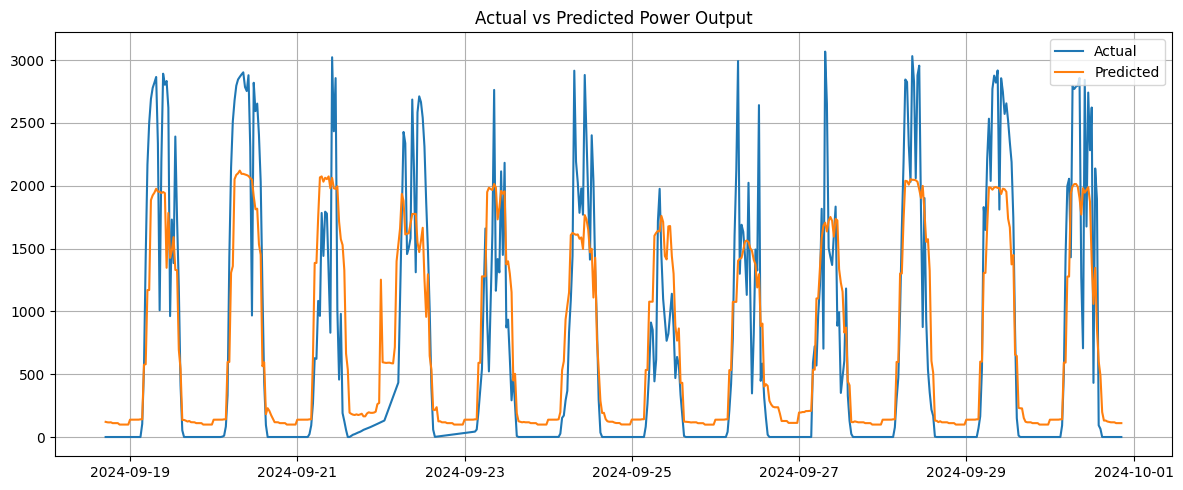

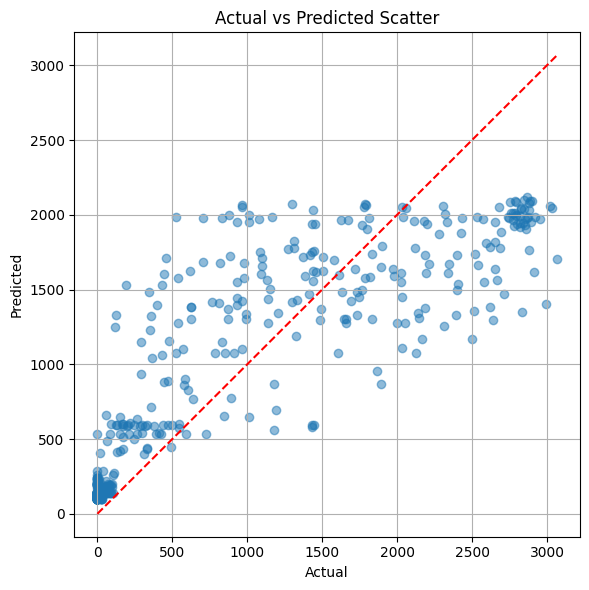

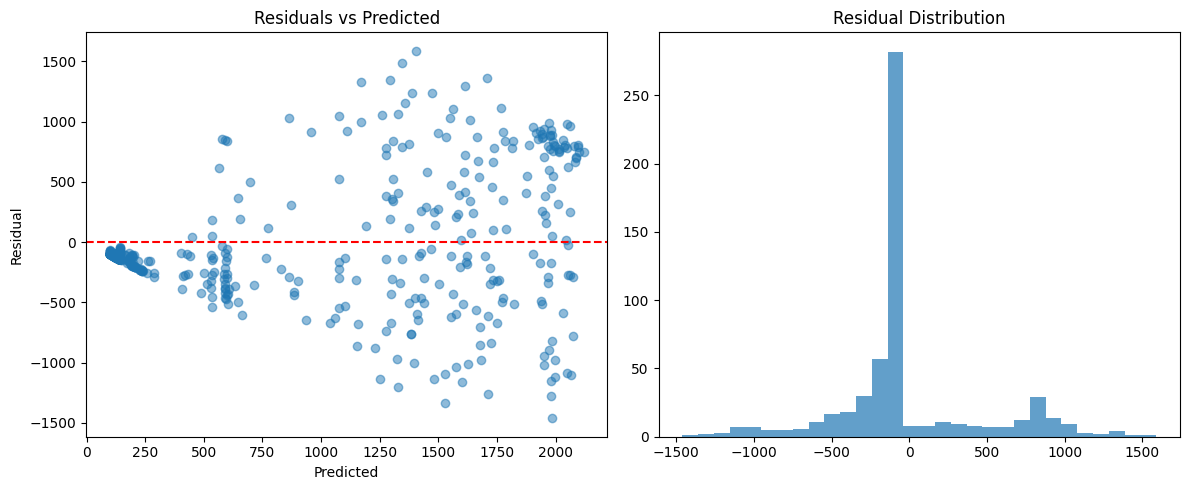

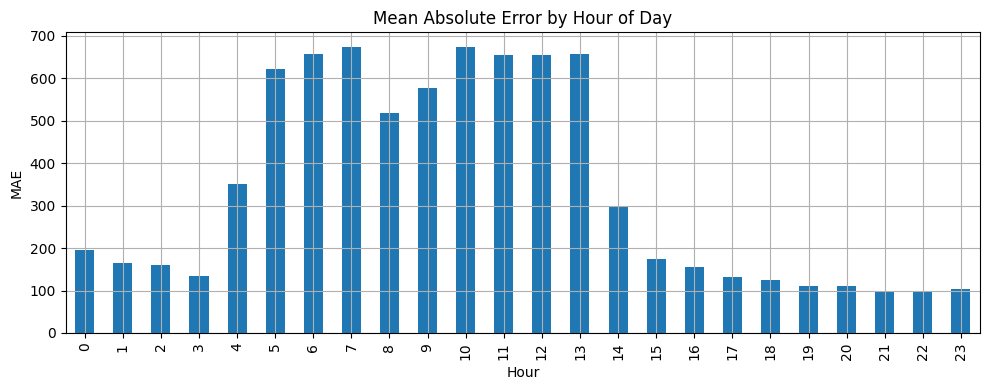

In [ ]:
# Prepare your dataframe
df = df.reset_index()
df = df.rename(columns={'index': 'datetime'})
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Initialize the model
model = SimpleForecastingModel(
    df,
    horizon_steps=6,  # 3 hours ahead if data is every 10 mins
    direct_features=['WMS 01 irradiance'],  # available at prediction time
)

# Run the full pipeline
model.run()